<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can try this notebook on a GPU but you will quickly be switching to a TPU. For this model it's worth it.

## Imports

In [1]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# little wrinkle: Kears models do not yet work on TPU if eager mode is enabled
# tf.enable_eager_execution()

Tensorflow version 1.13.1


## Colab-only auth

In [2]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too

## TPU detection

In [ ]:
# TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
# platforms: Colaboratory, AI Platform (ML Engine), Kubernetes and Deep Learning
# VMs created through the 'ctpu up' utility. If auto-detection is not available,
# you can pass the name of your TPU explicitly:
# tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME')
# tip: on a VM created with "ctpu up" the TPU has the same name as the VM.

try:
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # TPU detection
  
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
except ValueError:
  print("Running on GPU or CPU")
  tpu = None

## Configuration

In [4]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 128  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 32, there will be 93 batches per training epoch and 21 batch(es) per validation run.


In [5]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [6]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(GCS_PATTERN)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

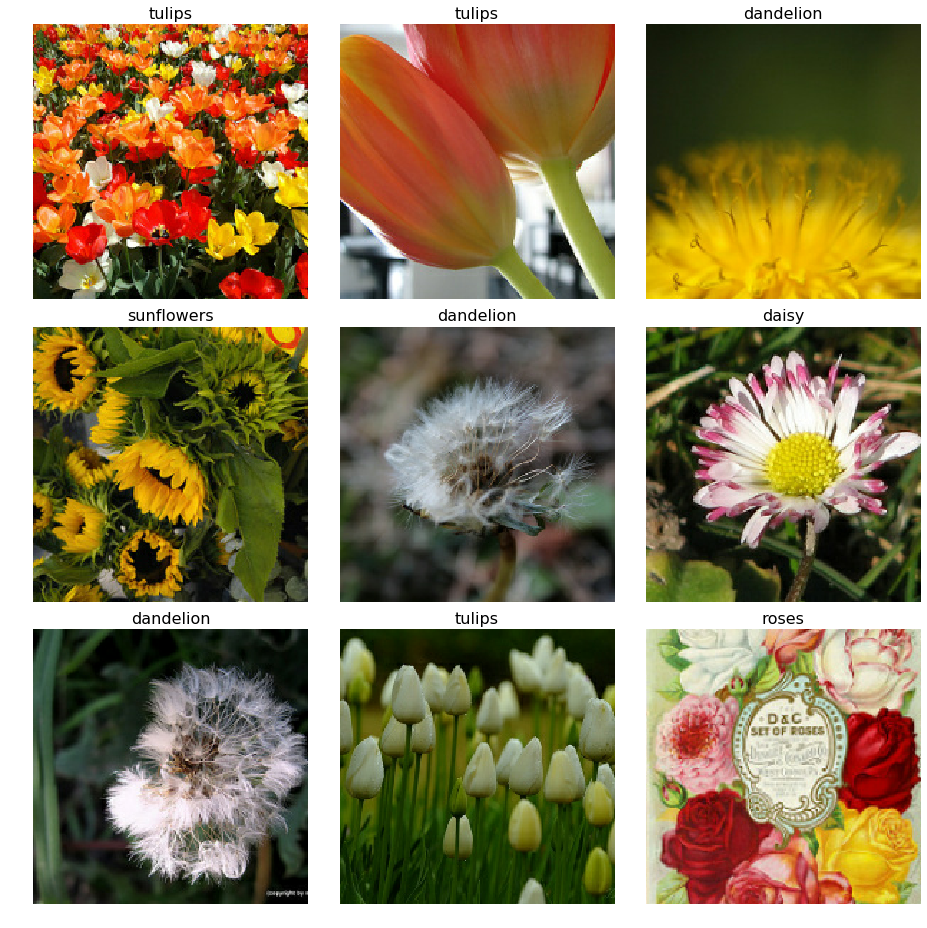

In [7]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [9]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

def get_training_dataset():
  return get_batched_dataset(training_filenames)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

## Model

In [10]:
model = tf.keras.Sequential([
    # little wrinkle: specifying the input shape as a Keras InputLayer does not
    # work on TPU yet. Please add an input shape on your first layer instead. 
    #l.InputLayer(input_shape=[*IMAGE_SIZE, 3]),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
    tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss= 'sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 30)      4350      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 60)        16260     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 90)        48690     
_________________________________________________________________
max_

## Training

In [11]:
if tpu:
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver()
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

In [19]:
EPOCHS = 30

if tpu:
  history = tpu_model.fit(get_training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                          validation_data=get_validation_dataset, validation_steps=validation_steps)
  # Little wrinkle: reading directly from dataset object not yet implemented
  # for Keras/TPU. Please use a function that returns a dataset.
else:
  history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=get_validation_dataset(), validation_steps=validation_steps)

Epoch 1/30
93/93 [==============================] - 6s 61ms/step - loss: 0.6534 - acc: 0.7557 - val_loss: 0.7488 - val_acc: 0.6786
Epoch 2/30
93/93 [==============================] - 5s 52ms/step - loss: 0.6492 - acc: 0.7534 - val_loss: 0.6572 - val_acc: 0.7604
Epoch 3/30
93/93 [==============================] - 4s 41ms/step - loss: 0.6385 - acc: 0.7567 - val_loss: 0.5667 - val_acc: 0.7693
Epoch 4/30
93/93 [==============================] - 4s 48ms/step - loss: 0.6033 - acc: 0.7745 - val_loss: 0.5207 - val_acc: 0.8065
Epoch 5/30
93/93 [==============================] - 4s 40ms/step - loss: 0.5793 - acc: 0.7826 - val_loss: 0.5576 - val_acc: 0.8006
Epoch 6/30
93/93 [==============================] - 3s 36ms/step - loss: 0.5374 - acc: 0.8034 - val_loss: 0.5952 - val_acc: 0.7664
Epoch 7/30
93/93 [==============================] - 3s 36ms/step - loss: 0.5210 - acc: 0.8034 - val_loss: 0.6959 - val_acc: 0.7485
Epoch 8/30
93/93 [==============================] - 3s 36ms/step - loss: 0.5206 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


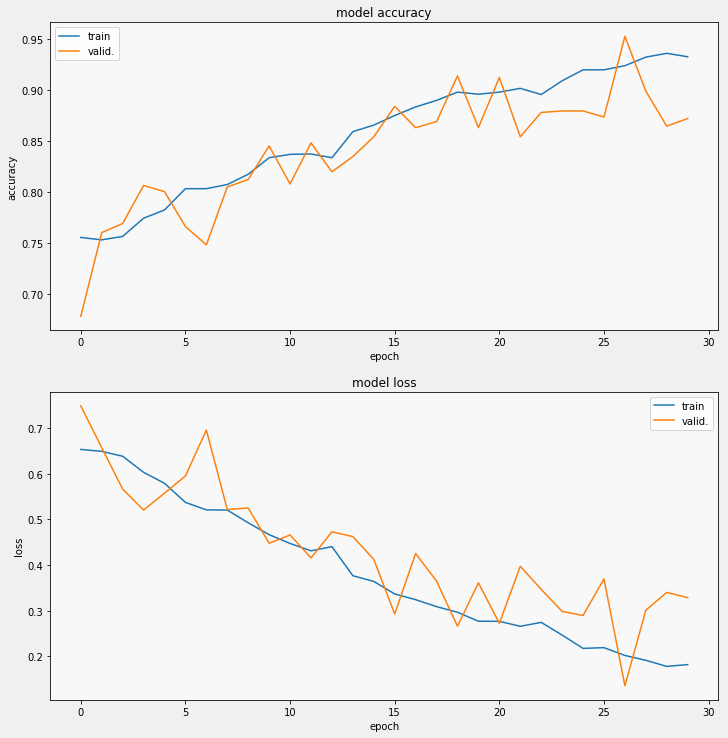

In [20]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [21]:
inference_model = model
if tpu:
  inference_model.set_weights(tpu_model.get_weights()) # this copies the weights from TPU to CPU

In [22]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = inference_model.predict(some_flowers, batch_size=16)
evaluations = inference_model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

160/160 [==============================] - 0s 1ms/sample - loss: 0.3340 - acc: 0.8500
['dandelion', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'roses', 'roses', 'roses', 'dandelion', 'daisy', 'daisy', 'dandelion', 'roses', 'roses', 'roses', 'daisy', 'dandelion', 'sunflowers', 'roses', 'daisy', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'roses', 'dandelion', 'tulips', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'roses', 'roses', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'roses', 'daisy', 'daisy', 'tulips', 'sunflowers', 'tulips', 'roses', 'roses', 'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion', 'roses', 'tulips', 'tulips', 'daisy', 'sunflowers', 'sunflowers', 'dandelion', 'daisy', 'roses', 'roses', 'roses', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'roses

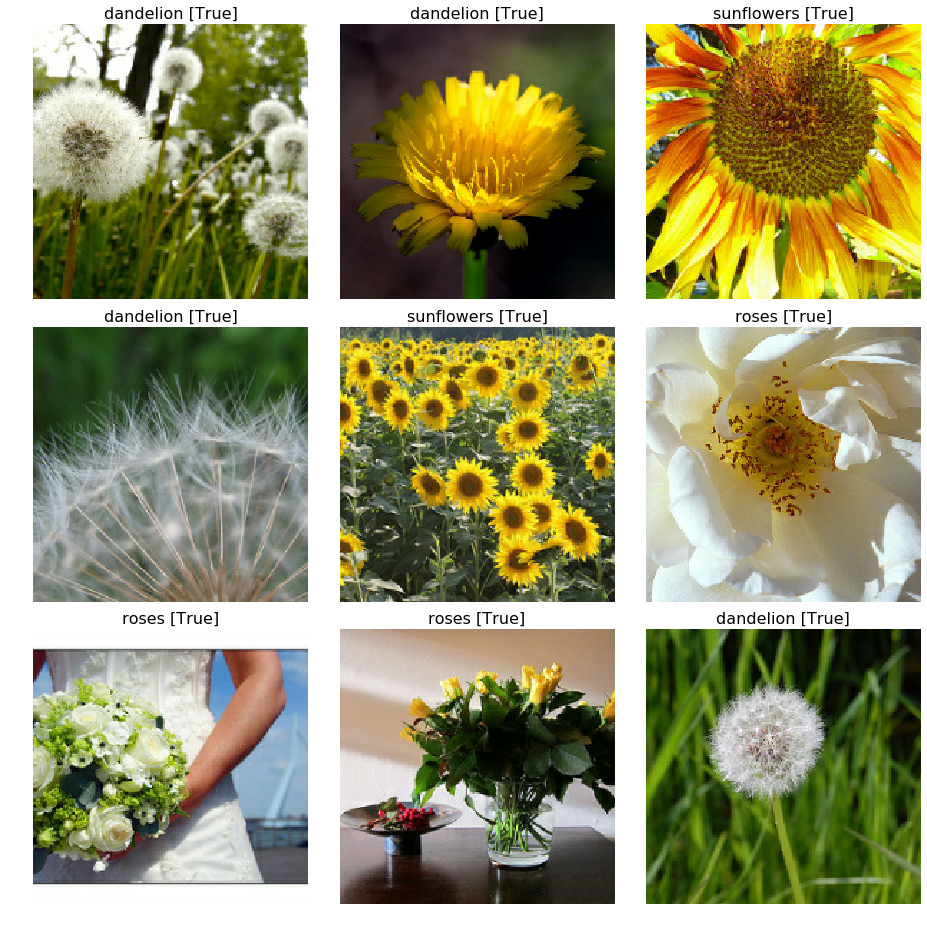

In [23]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
